In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

## Prepare the Dataset
First define a few utilities for preparing and visualizing your dataset.

In [2]:
# Create a pairs of images and generate y values if those pair are from the same class
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    # Find the safe number of pairs based on the minimum class
    n = min([len(digit_indices[d]) for d in range(10)]) - 1

    for d in range(10):
        for i in range(n):
            # Positive pair
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            # Negative pair
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]

    return np.array(pairs), np.array(labels)

# A helper function for generating pairs and their similarity labels
def create_pairs_on_set(images, labels):
    """
    function is a helper function that takes in a set of images and their corresponding labels, 
    then returns pairs of images along with their relationship labels 
    (either 1 for positive pairs or 0 for negative pairs).
    """
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype(np.float32)

    return pairs, y

# Showing an image
def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

We can now download and prepare our train and test sets. We will also create pairs of images that will go into the multi-input model.

In [3]:
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Prepare the train and test images
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Normalize values
train_images = train_images / 255.
test_images = test_images / 255.0

# Create pairs on train and test dataset
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

Now, we can show and plot some of the pairs and see their y values, which shows if they are from the same class based on the `fashion_mnist` dataset.

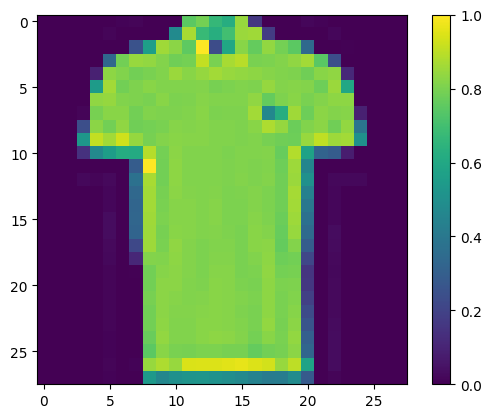

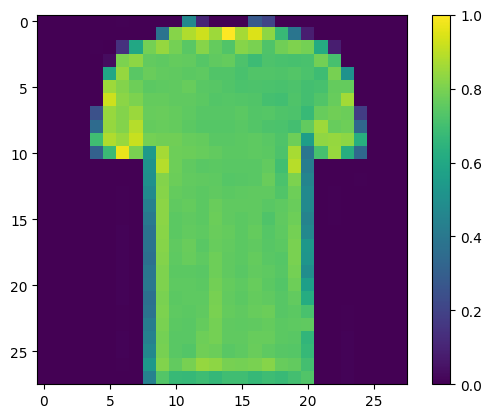

1.0


In [4]:
# array index
this_pair = 10

# show images at this index
show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

# print the label for this pair
print(ts_y[this_pair])

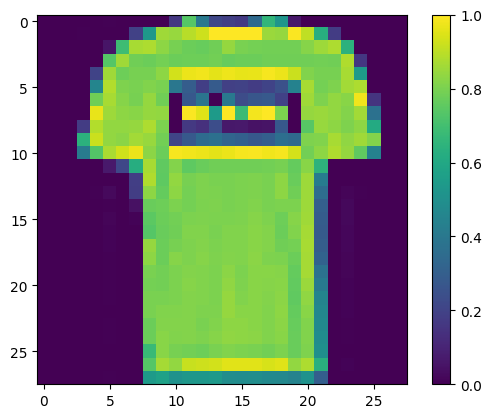

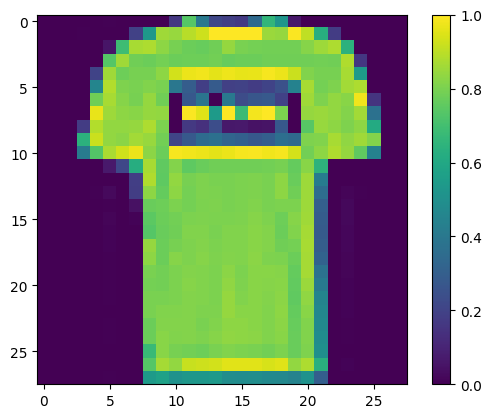

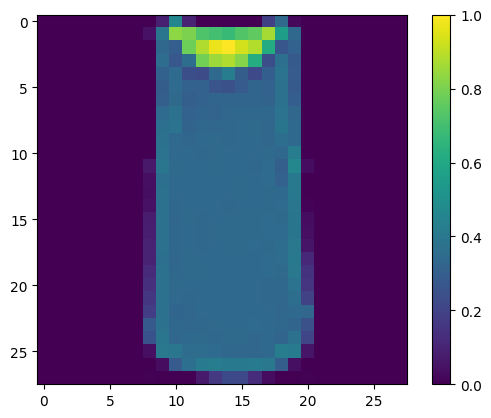

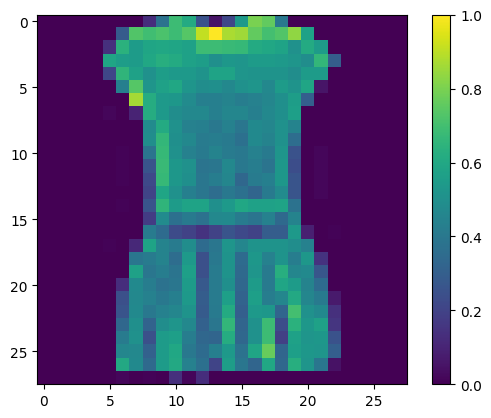

In [5]:
# print other pairs

show_image(tr_pairs[:,0][0])
show_image(tr_pairs[:,0][1])

show_image(tr_pairs[:,1][0])
show_image(tr_pairs[:,1][1])

## Build the Model
Next, we'll define some utilities for building our model. In this section
> **We're trying a siamese network with base networks as below**

![siamese network](../images/base-model_siamese.png)

> **And the whole and final model for the siamese network is like below:**

![siamese network](../images/model_siamese.png)

In [6]:
# A function that returns the base model for two inputs
def initialize_base_network():
    input_layer = Input(shape=(28, 28), name='base_input')
    x = Flatten(name='base_flatten_input')(input_layer)
    x = Dense(128, activation='relu', name='base_first_dense')(x)
    x = Dropout(0.1, name='base_first_dropout')(x)
    x = Dense(128, activation='relu', name='base_second_dense')(x)
    x = Dropout(0.1, name='base_second_dropout')(x)
    x = Dense(128, activation='relu', name='base_third_dense')(x)

    # This function returns the Model object
    return Model(inputs=input_layer, outputs=x)

# Defining a Euclidean distance function to score each pair of image embeddings
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

# Defining a function to calculate the output shape of euclidean disance function
def euclidean_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

Let's see how our base network looks. This is where the two inputs will pass through to generate an output vector.

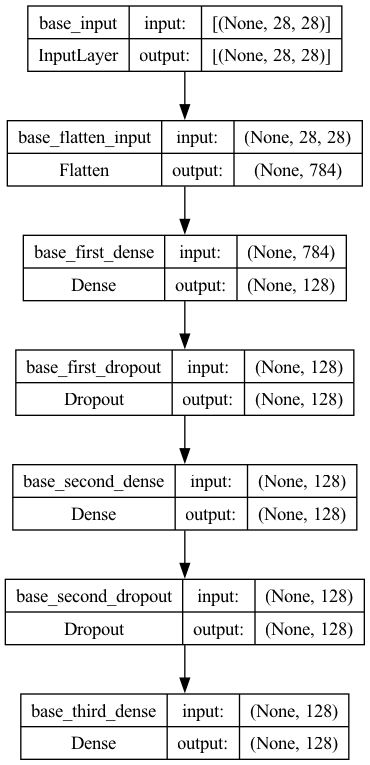

In [7]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True)

Let's now build the Siamese network. The plot will show two inputs going to the base network.

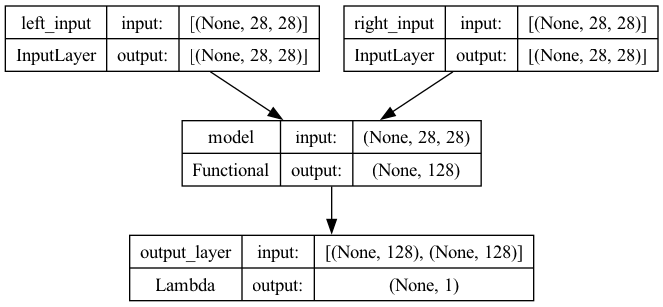

In [9]:
# create the left input and point to the base network
input_a = Input(shape=(28, 28), name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(28, 28), name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
# Using Lambda layer
output = Lambda(euclidean_distance, name='output_layer', output_shape=euclidean_dist_output_shape)\
               ([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model(inputs=[input_a, input_b], outputs=output)

# Plotting the whole siamese network
plot_model(model, show_shapes=True, show_layer_names=True)

### Lambda Layer Components:
1. **Function:** The primary argument to the Lambda layer is a function, in this case euclidean_distance. This function should accept a tensor (or list of tensors) and return a tensor. The Lambda layer essentially allows this function to be used as a Keras layer in the model.

2. **Input to the Lambda Layer:** The input to the Lambda layer is specified by calling it like a function: Lambda(...)(input). In your code, the input is the list of tensors [vect_output_a, vect_output_b], which are the embeddings produced by the twin branches of the Siamese network.

3. **output_shape Argument:** Since the Lambda layer can wrap an arbitrary function, Keras might not be able to automatically infer the shape of the output tensor. Thus, you often need to specify the output_shape argument. Here, you're providing the eucl_dist_output_shape function, which we discussed earlier, to inform Keras of the shape of the output tensor.

### How Does It Work?
- When the model is trained or used for prediction, data flows through the network like so:

vect_output_a and vect_output_b are produced by feeding data through the Siamese twins (both using the base_network).

These embeddings are then passed to the Lambda layer.

- Inside the Lambda layer, the euclidean_distance function is applied to these embeddings, computing the Euclidean distance between them.

The computed distance (a tensor) is the output of the Lambda layer.

## Train the Model
You can now define the custom loss for our network and start training.

In [13]:
# Define a contrastive loss function
def contrastive_loss_with_margin(margin=1):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(0.0, margin - y_pred))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [14]:
rms = RMSprop()
# Compile the model
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)

# Fit the model
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
                   epochs=20, batch_size=128,
                   validation_data=([ts_pairs[:, 0], ts_pairs[:, 1]], ts_y))

Epoch 1/20
938/938 [==============================] - 3s 3ms/step - loss: 0.1093 - val_loss: 0.0834
Epoch 2/20
938/938 [==============================] - 2s 3ms/step - loss: 0.0789 - val_loss: 0.0752
Epoch 3/20
938/938 [==============================] - 2s 3ms/step - loss: 0.0706 - val_loss: 0.0693
Epoch 4/20
938/938 [==============================] - 2s 3ms/step - loss: 0.0660 - val_loss: 0.0722
Epoch 5/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0633 - val_loss: 0.0663
Epoch 6/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0611 - val_loss: 0.0647
Epoch 7/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0596 - val_loss: 0.0660
Epoch 8/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0578 - val_loss: 0.0645
Epoch 9/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0568 - val_loss: 0.0643
Epoch 10/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0559 - val_loss: 0.0639

## Model Evaluation
As usual, we can evaluate our model by computing the accuracy and observing the metrics during training.

In [15]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [16]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 [==============================] - 0s 474us/step
Loss = 0.06131155043840408, Train Accuracy = 0.9440240040006668 Test Accuracy = 0.9173673673673673


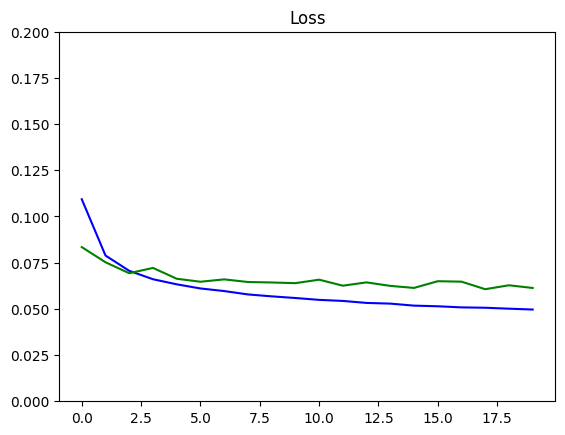

In [17]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)